<a href="https://colab.research.google.com/github/iupui-soic/pybootcamp/blob/main/Vaibhav_chap2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# Importing necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import tarfile
import os
import urllib
import urllib.request
from pathlib import Path

#load the housing data
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [56]:
housing = load_housing_data()

In [57]:
# Exploratory Data Analysis
print(housing.head())
print(housing.describe())
print(housing["ocean_proximity"].value_counts())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
          longitude      latitude  housing_median_age   total_rooms  \
coun

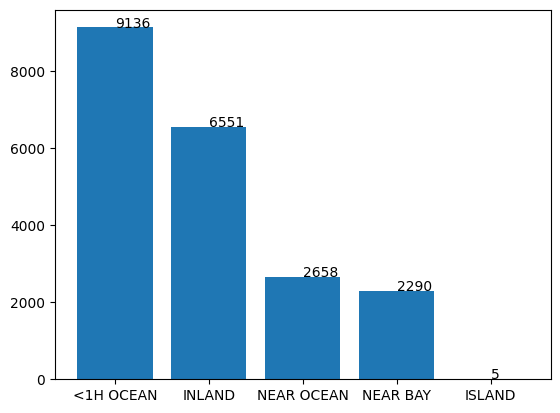

In [58]:
# Bar plot for ocean proximity category
counts = housing["ocean_proximity"].value_counts()
categories = list(counts.index)
count_values = list(counts.values)

plt.bar(categories, count_values)
for i, v in enumerate(count_values):
    plt.text(i, v, str(v))
plt.show()

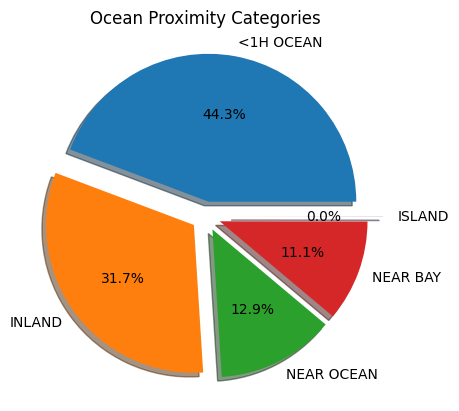

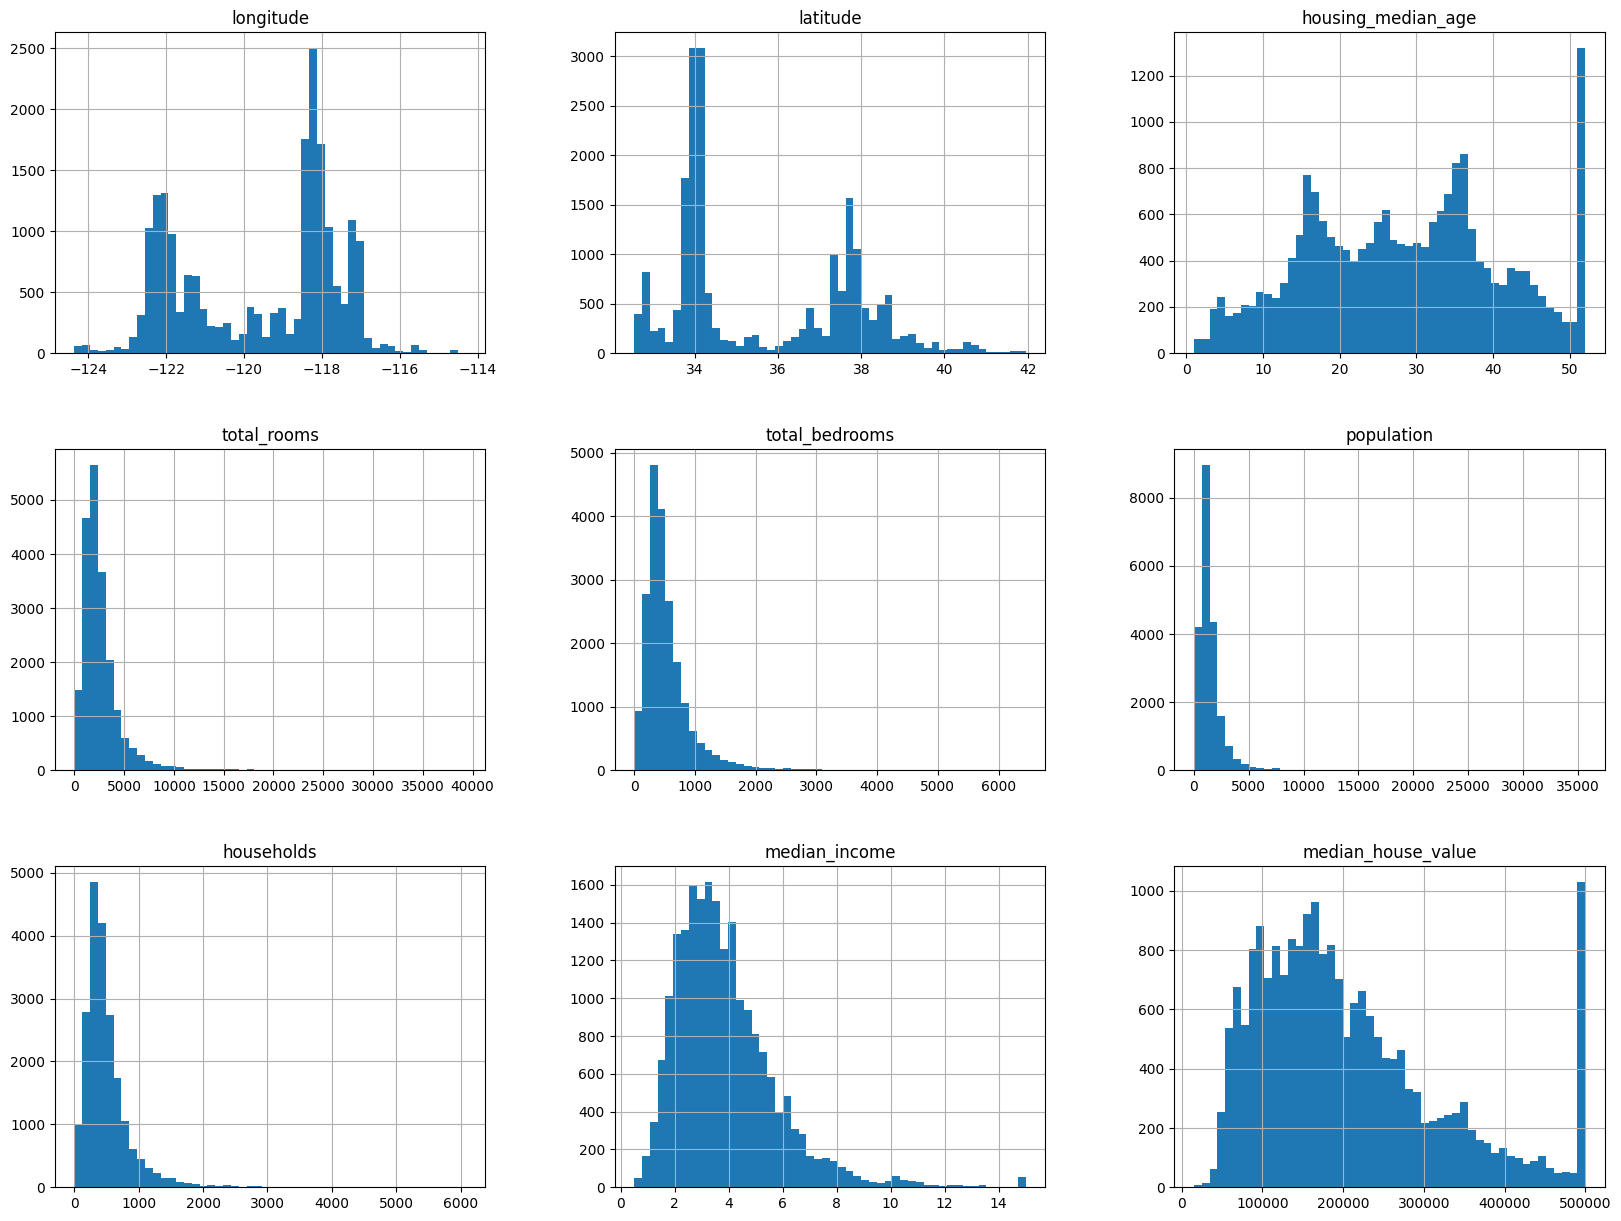

In [59]:
# Pie chart for ocean proximity categories
plt.pie(count_values, explode=[0.1, 0.1, 0.1, 0.1, 0.2], labels=categories, autopct='%1.1f%%', shadow=True)
plt.title("Ocean Proximity Categories")
plt.show()

# Histograms of the housing data
housing.hist(bins=50, figsize=(20, 15))
plt.show()

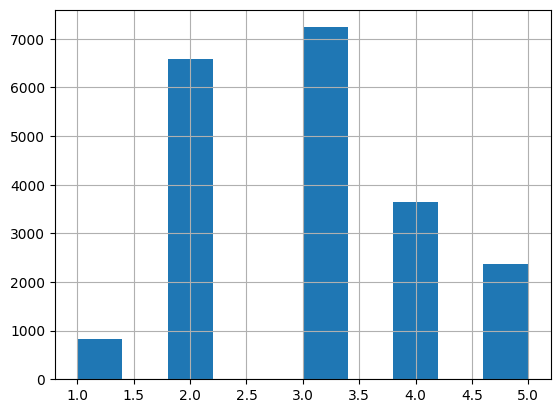

income_cat
3    1447
2    1316
4     728
5     472
1     165
Name: count, dtype: int64
income_cat
3    5789
2    5265
4    2911
5    1890
1     657
Name: count, dtype: int64
income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64


In [60]:
# Data preprocessing and splitting into train and test data
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()
plt.show()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

print(strat_test_set["income_cat"].value_counts())  # Test set
print(strat_train_set["income_cat"].value_counts())  # Train set
print(housing["income_cat"].value_counts())  # Total set

In [61]:
# Removing income_cat attribute
for set_ in (strat_test_set, strat_train_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Copying the train set
housing = strat_train_set.copy()

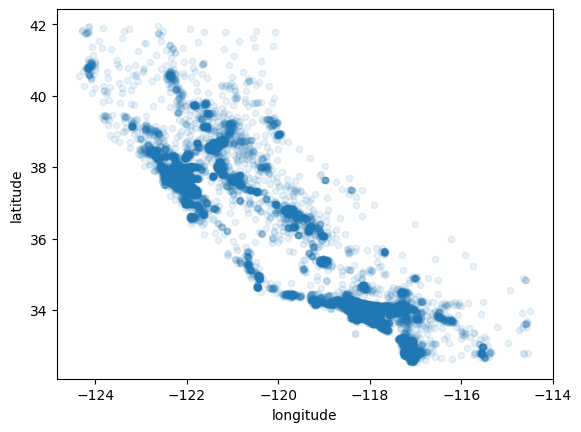

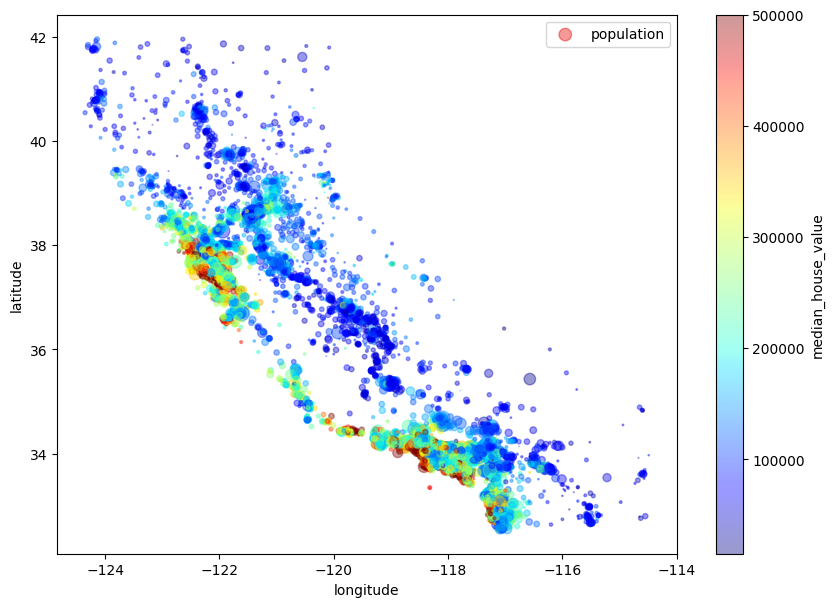

In [62]:
# Scatter plot for geographical data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"] / 100,
             label="population", figsize=(10, 7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

In [64]:
# Looking for correlation

corr_matrix = housing.corr()

ValueError: could not convert string to float: 'NEAR BAY'

NameError: name 'save_fig' is not defined

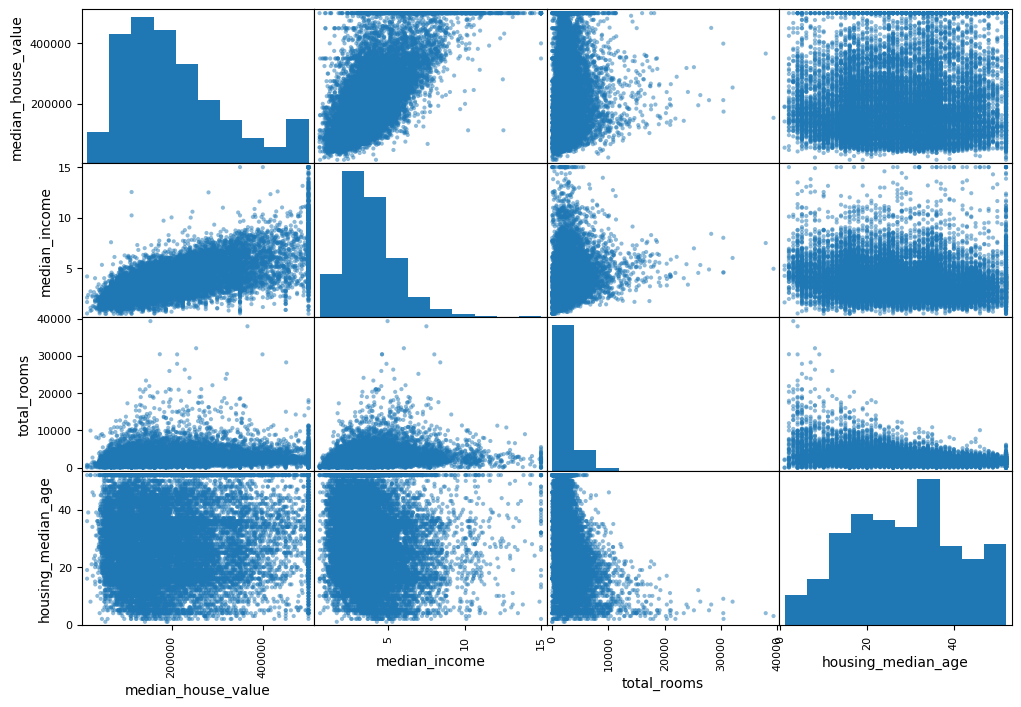

In [65]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")  # extra code
plt.show()

NameError: name 'save_fig' is not defined

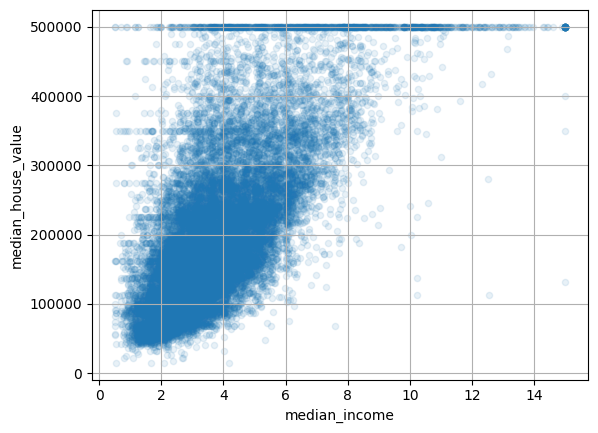

In [54]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")  # extra code
plt.show()

In [11]:
# Select only numeric columns
numeric_housing = housing.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_housing.corr()

# Print the correlation of all columns with 'median_house_value'
print(corr_matrix["median_house_value"].sort_values(ascending=False))

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64


In [12]:
# Separating label and features
housing = strat_train_set.drop("median_house_value", axis=1)
housing_label = strat_train_set["median_house_value"].copy()


In [13]:
# Data Cleaning using imputer to fill missing data
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)


In [15]:
# Converting categorical values to numerical using ordinal encoder
ordinal_encoder = OrdinalEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_encoded[:5])

print(ordinal_encoder.categories_)

[[3.]
 [0.]
 [1.]
 [1.]
 [4.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [16]:
# Using OneHotEncoder to avoid issues with ordinal encoding
one_hot_enc = OneHotEncoder()
housing_cat_1hot = one_hot_enc.fit_transform(housing_cat)
print(housing_cat_1hot.toarray())
print(one_hot_enc.categories_)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [17]:
# Creating a custom transformer that adds new columns to data
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedroom_per_room=True):
        self.add_bedroom_per_room = add_bedroom_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedroom_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [18]:
# Creating pipeline for numerical attributes
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attributes_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler()),
])

In [19]:
# Full pipeline including numerical and categorical attributes
num_attributes = list(housing_num)
cat_attributes = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", OneHotEncoder(), cat_attributes),
])


In [20]:
# Preparing the data
housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared.shape)

(16512, 16)


Model Training and Evaluation

In [22]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(housing_prepared, housing_label)

# Predictions with Linear Regression
some_data = housing.iloc[:5]
some_labels = housing_label[:5]
some_data_prepared = full_pipeline.transform(some_data)
some_data_prediction = linear_reg.predict(some_data_prepared)
print(f"Predictions: {some_data_prediction}")

Predictions: [276608.27419651 333603.0303772  118237.5726011  108255.75159886
 308943.82732346]


In [23]:
# Evaluating Linear Regression with RMSE
lin_mse = mean_squared_error(housing_label, linear_reg.predict(housing_prepared))
lin_rmse = np.sqrt(lin_mse)
print(f"Linear Regression RMSE: {lin_rmse}")

Linear Regression RMSE: 67769.12117461127


In [24]:
# Decision Tree Regressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_label)


DecisionTreeRegressor()

In [25]:
# Evaluating Decision Tree with RMSE
tree_mse = mean_squared_error(housing_label, tree_reg.predict(housing_prepared))
tree_rmse = np.sqrt(tree_mse)
print(f"Decision Tree RMSE: {tree_rmse}")

Decision Tree RMSE: 0.0


In [31]:
from sklearn.model_selection import cross_val_score

# in cross_val_score our data is divided into 10 equal parts. 9 parts are used to train model
# and one is left for evaluating. Same is repeated for eacch part of data
scores = cross_val_score(tree_reg,housing_prepared,housing_label,scoring='neg_mean_squared_error',cv=10)
tree_rmse_score = np.sqrt(-scores)


def display_scores(scores):
    print('Scores: ',scores)
    print('Mean: ',scores.mean())
    print('Standard Deviation: ',scores.std())


display_scores(tree_rmse_score)



Scores:  [67301.76680576 68000.56749545 67841.52851015 74776.17084601
 71194.24331427 69956.83236794 72273.20921091 73107.78200289
 69933.85560093 69284.77178472]
Mean:  70367.07279390168
Standard Deviation:  2327.474416335153


In [32]:
#Performing linear regression with cross validation
lin_scores = cross_val_score(linear_reg,housing_prepared,housing_label,scoring='neg_mean_squared_error',cv=10)
display_scores(np.sqrt(-lin_scores))

Scores:  [69717.57852026 66650.26617871 66488.43193213 70478.22519838
 66837.93229332 68220.31091521 66922.70445332 69700.47781664
 67122.26131607 67802.47918508]
Mean:  67994.06678091262
Standard Deviation:  1394.937701550329


In [33]:
# Performing random forest regressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_label)
np.sqrt(mean_squared_error(housing_label,forest_reg.predict(housing_prepared)))

18605.19145264236

In [34]:
forest_scores = cross_val_score(forest_reg,housing_prepared,housing_label,scoring='neg_mean_squared_error',cv=10)
display_scores(np.sqrt(-forest_scores))

Scores:  [48746.62216839 50021.40759635 47524.36047151 50121.39354729
 49075.02368929 49640.88053329 50352.80578093 51424.2360047
 50254.07810122 50185.69313928]
Mean:  49734.65010322489
Standard Deviation:  1012.2915475043052


In [66]:
from sklearn.svm import SVR

svr_reg = SVR(kernel='linear')
svr_reg.fit(housing_prepared, housing_label)
svr_scores = cross_val_score(svr_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error', cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores:  [113538.27487704 114028.34921524 109143.71508685 110279.16743333
 110609.80770625 112580.84267984 111629.7093742  109110.11026557
 108699.61055577 113288.52897014]
Mean:  111290.81161642264
Standard Deviation:  1894.2572364204802


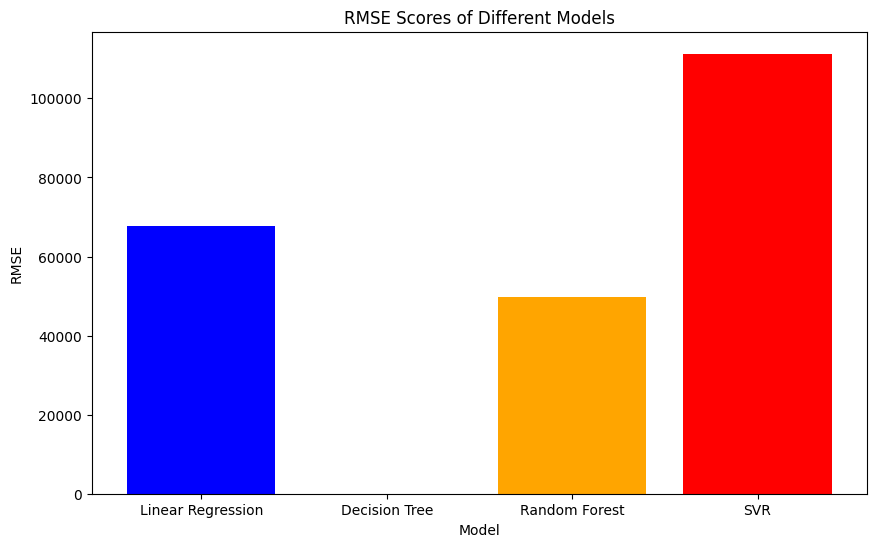

In [68]:
import matplotlib.pyplot as plt

# Collecting RMSE scores for all models
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'SVR']
rmse_scores = [lin_rmse, tree_rmse, np.sqrt(-forest_scores.mean()), svr_rmse_scores.mean()]

# Plotting the RMSE scores
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_scores, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Scores of Different Models')
plt.show()